In [ ]:
SSimport pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving edge_df.csv to edge_df (1).csv
Saving node_df.csv to node_df (1).csv


In [ ]:
node_df = pd.read_csv("node_df.csv")
edge_df = pd.read_csv("edge_df.csv")

In [ ]:
NUM_NODES = node_df["node_id"].max() + 1
FEATURE_DIM = 3  # views, likes, comments
HIDDEN_DIM = 16  # Memory 차원 수

In [ ]:
def safe_log(x):
    return torch.log1p(torch.tensor(x, dtype=torch.float32))

node_features = torch.zeros(NUM_NODES, FEATURE_DIM)
for _, row in node_df.iterrows():
    node_id = int(row["node_id"])
    node_features[node_id] = safe_log([row["views"], row["likes"], row["comments"]])

In [ ]:
memory = torch.zeros(NUM_NODES, HIDDEN_DIM)
gru = nn.GRUCell(input_size=FEATURE_DIM, hidden_size=HIDDEN_DIM)

In [ ]:
edge_df_sorted = edge_df.sort_values(by="timestamp")

In [ ]:
for _, row in tqdm(edge_df_sorted.iterrows(), total=len(edge_df_sorted)):
    src = int(row["src"])
    dst = int(row["dst"])
    src_feat = node_features[src]
    prev_state = memory[dst]
    updated_state = gru(src_feat.unsqueeze(0), prev_state.unsqueeze(0)).squeeze(0)
    memory[dst] = updated_state

100%|██████████| 17931/17931 [00:05<00:00, 3431.03it/s]


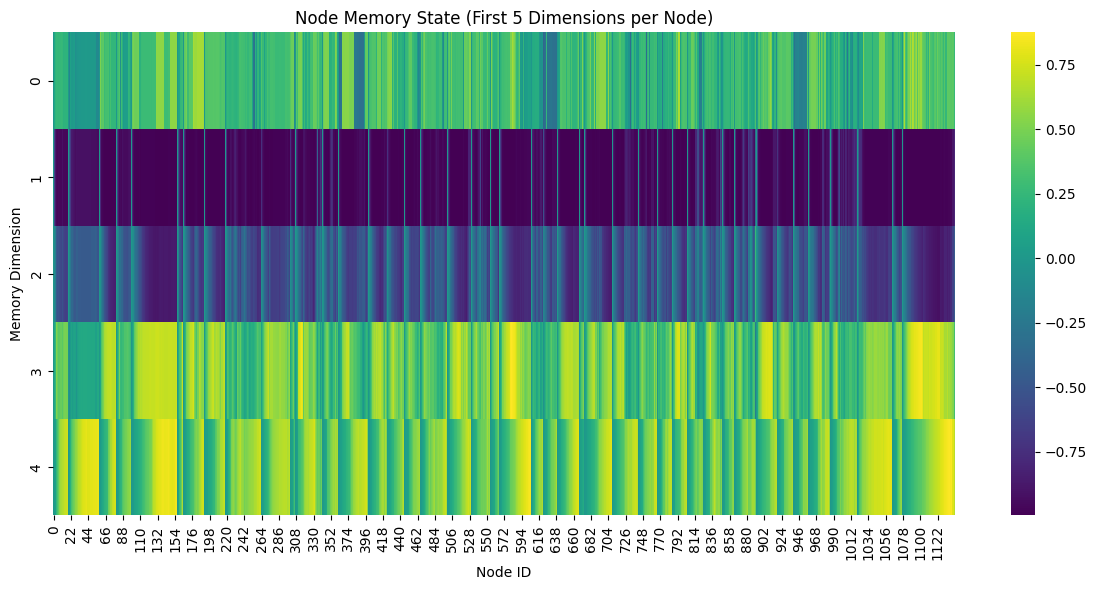

In [ ]:
memory_sample = memory[:, :5].detach().numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(memory_sample.T, cmap="viridis", cbar=True)
plt.title("Node Memory State (First 5 Dimensions per Node)")
plt.xlabel("Node ID")
plt.ylabel("Memory Dimension")
plt.tight_layout()
plt.show()